In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu
from muon import atac as ac

In [2]:
#!wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5

In [3]:
mdata = mu.read_10x_h5("pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5")

/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5


/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


In [4]:
mdata

MuData object with n_obs × n_vars = 2711 × 134920
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	2711 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	2711 x 98319
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [5]:
atac = mdata.mod['atac']
atac  # an AnnData object

AnnData object with n_obs × n_vars = 2711 × 98319
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [6]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

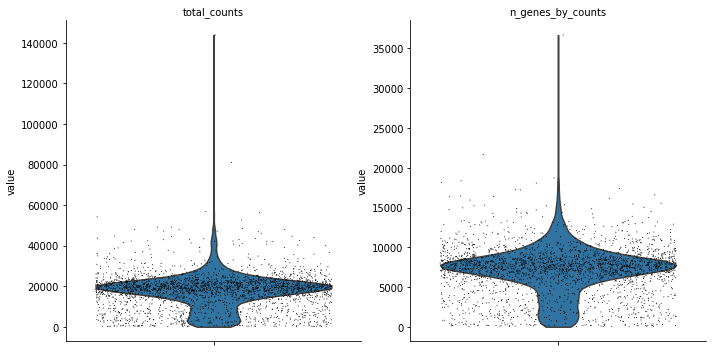

In [7]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [8]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))

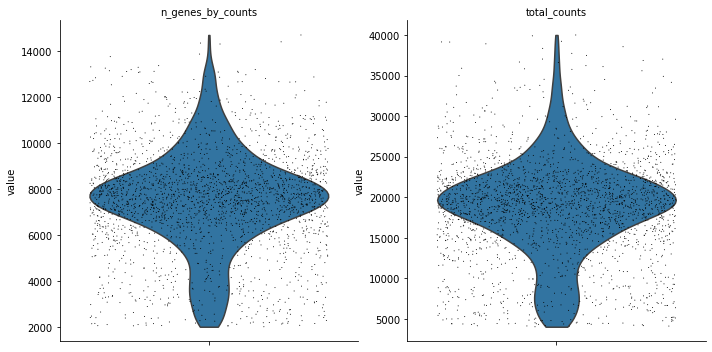

In [9]:
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

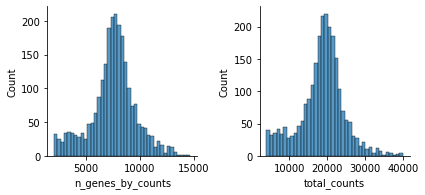

In [10]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'])

In [11]:
from pyjaspar import jaspardb
import pychromvar as pc
from scipy import sparse

In [12]:
pc.add_peak_seq(atac, genome_file="/home/rs619065/rgtdata/hg38/genome_hg38.fa", delimiter=":|-")

100%|██████████| 98079/98079 [00:01<00:00, 73547.97it/s]


In [13]:
pc.add_gc_bias(atac)

100%|██████████| 98079/98079 [00:01<00:00, 87192.22it/s]


In [14]:
%%time
pc.get_bg_peaks(atac, n_jobs=3)

CPU times: user 53.9 s, sys: 10.2 s, total: 1min 4s
Wall time: 35.2 s


In [15]:
atac

AnnData object with n_obs × n_vars = 2450 × 98079
    obs: 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'seq'
    varm: 'gc_bias', 'bg_peaks'

In [16]:
jdb_obj = jaspardb(release='JASPAR2020')
motifs = jdb_obj.fetch_motifs(
    collection = 'CORE',
    tax_group = ['vertebrates'])

In [17]:
%%time
pc.match_motif(atac, motifs=motifs)

100%|██████████| 98079/98079 [01:07<00:00, 1445.63it/s]


CPU times: user 1min 12s, sys: 120 ms, total: 1min 12s
Wall time: 1min 12s


In [19]:
%%time
pc.compute_deviations(atac)

Computing expectation reads per cell and peak...
Computing observed deviations...
Computing background deviations...
CPU times: user 1min 23s, sys: 58.7 s, total: 2min 21s
Wall time: 3min 48s
